In [1]:
import os
import pandas as pd

# --- STEP 1: SMART FILE FINDER (Fixes Path Errors) ---
def find_file(filename):
    # Searches current folder, parent folder, and standard Kaggle/Colab paths
    search_paths = ['.', '..', '/kaggle/input', '/content'] 
    for path in search_paths:
        if os.path.exists(path):
            for root, dirs, files in os.walk(path):
                if filename in files:
                    return os.path.join(root, filename)
    return None

print("🕵️‍♂️ Searching for dataset files...")
bbox_path = find_file('train_bboxes.csv')

if not bbox_path:
    print("❌ CRITICAL ERROR: Could not find 'train_bboxes.csv'.")
    print("If you are on Kaggle, ensure you clicked 'Add Data' in the right sidebar.")
else:
    print(f"✅ File Found: {bbox_path}")

    # --- STEP 2: DATA INTELLIGENCE CHECK ---
    df = pd.read_csv(bbox_path)

    print("\n📊 --- ANALYSIS REPORT ---")
    
    # Check 1: Are classes balanced?
    print("\n1️⃣ Class Distribution:")
    print(df['class'].value_counts())

    # Check 2: Box Dimensions (The 'Secret' Insight)
    df['w'] = df['x_max'] - df['x_min']
    df['h'] = df['y_max'] - df['y_min']
    print("\n2️⃣ Bounding Box Sizes (Min/Max/Mean):")
    # This will tell us if all objects are the exact same size
    print(df[['w', 'h']].describe().loc[['min', 'max', 'mean']])

    # Check 3: How many objects per image?
    print("\n3️⃣ Objects per Image (Crowd Density):")
    print(df.groupby('image_name').size().describe().loc[['min', 'max', 'mean']])

🕵️‍♂️ Searching for dataset files...
✅ File Found: ../input/solidworks-ai-hackathon/train_bboxes.csv

📊 --- ANALYSIS REPORT ---

1️⃣ Class Distribution:
class
washer         6434
bolt           6229
locatingpin    6185
nut            6134
Name: count, dtype: int64

2️⃣ Bounding Box Sizes (Min/Max/Mean):
          w      h
min   224.0  224.0
max   224.0  224.0
mean  224.0  224.0

3️⃣ Objects per Image (Crowd Density):
min     1.0000
max     4.0000
mean    2.4982
dtype: float64


✅ Images found in: ../input/solidworks-ai-hackathon/train/train


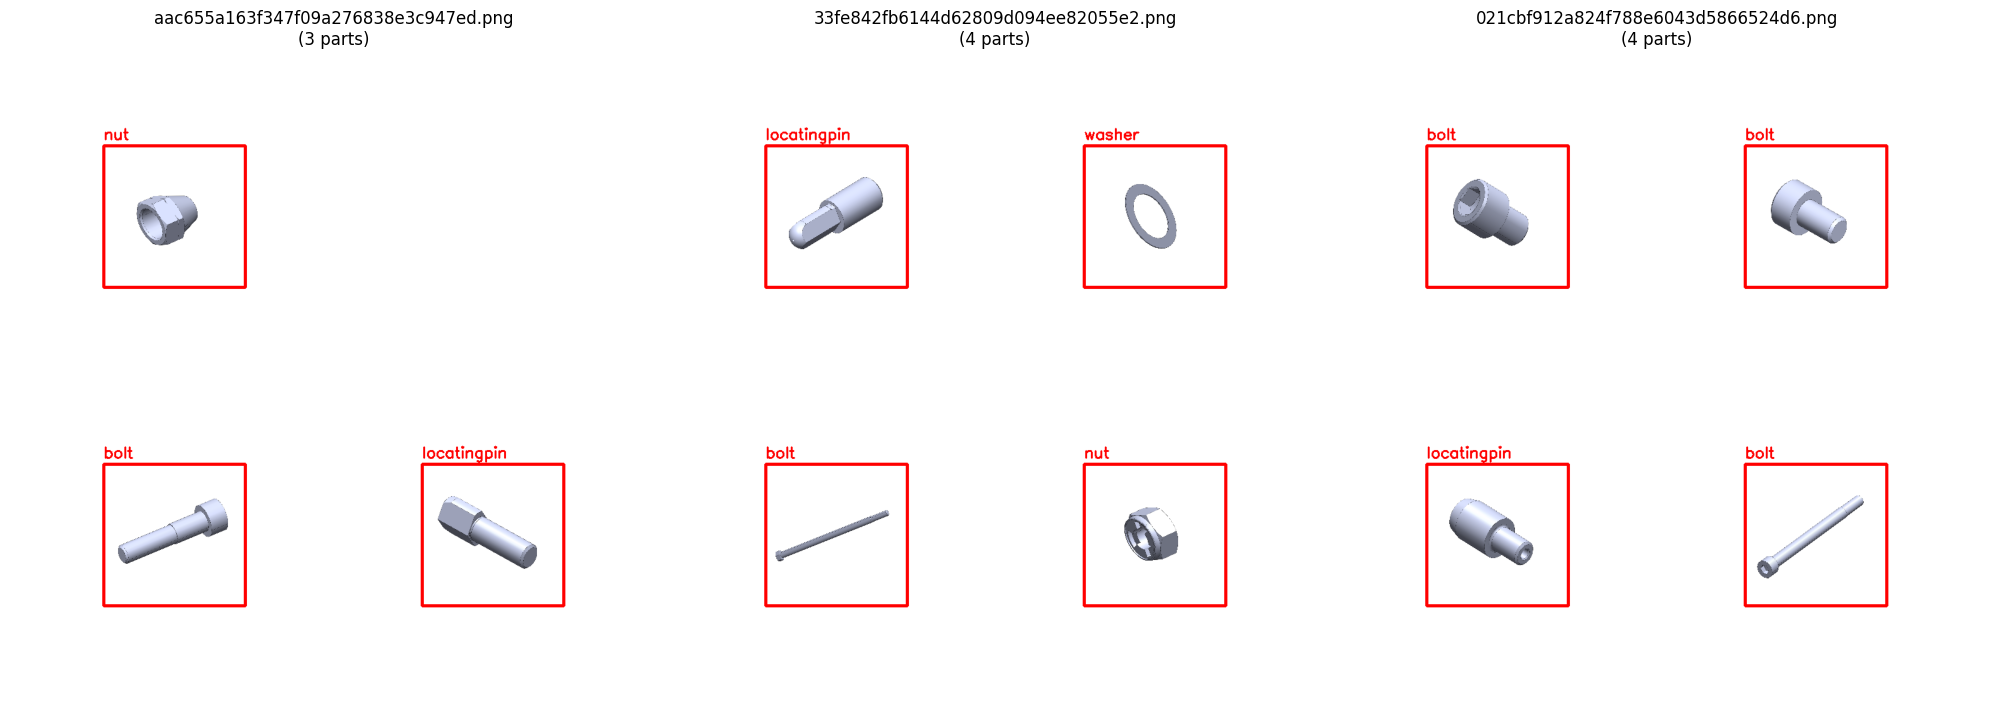

In [2]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

# --- CONFIGURATION ---
# We use the path we found in the previous step
BASE_DIR = '../input/solidworks-ai-hackathon'
BBOX_PATH = os.path.join(BASE_DIR, 'train_bboxes.csv')

# Finding the image directory can be tricky (sometimes it's train/train or just train)
# We look for where the images actually live
possible_img_dirs = [
    os.path.join(BASE_DIR, 'train', 'train'),
    os.path.join(BASE_DIR, 'train')
]
IMG_DIR = None
for d in possible_img_dirs:
    if os.path.exists(d) and len(os.listdir(d)) > 10:
        IMG_DIR = d
        break

if IMG_DIR is None:
    print(f"⚠️ Could not automatically find the image folder in {BASE_DIR}")
    print("Please check if the folder is named 'train' or 'train/train'")
else:
    print(f"✅ Images found in: {IMG_DIR}")
    
    # --- VISUALIZATION LOGIC ---
    df = pd.read_csv(BBOX_PATH)
    
    # Pick 3 random images
    sample_images = df['image_name'].sample(3).values

    plt.figure(figsize=(20, 8))

    for i, img_name in enumerate(sample_images):
        full_path = os.path.join(IMG_DIR, img_name)
        
        # Read and Convert Image
        img = cv2.imread(full_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get Boxes for this image
        boxes = df[df['image_name'] == img_name]
        
        # Draw on image
        for _, row in boxes.iterrows():
            x1, y1 = int(row['x_min']), int(row['y_min'])
            x2, y2 = int(row['x_max']), int(row['y_max'])
            label = row['class']
            
            # Draw Rectangle (Red)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
            # Draw Label
            cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
            
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{img_name}\n({len(boxes)} parts)")

    plt.tight_layout()
    plt.show()

In [3]:
import pandas as pd
import os
import shutil
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import cv2

# --- CONFIGURATION ---
# Use the paths we found in Cell 1
# (Make sure these match your output from Cell 1)
BBOX_CSV = bbox_path  # From previous cell
# We need the folder where the images LIVE. 
# Based on your previous output, it's likely inside 'train/train' or just 'train'
# We will auto-detect the image folder again to be safe.
if os.path.exists('../input/solidworks-ai-hackathon/train/train'):
    IMG_DIR = '../input/solidworks-ai-hackathon/train/train'
else:
    IMG_DIR = '../input/solidworks-ai-hackathon/train'

OUTPUT_DIR = './yolo_dataset'

# Class Mapping (CRITICAL: Must match submission order)
CLASS_MAP = {
    'bolt': 0,
    'locatingpin': 1,
    'nut': 2,
    'washer': 3
}

# --- 1. SETUP FOLDERS ---
print("📂 Creating Folder Structure...")
for split in ['train', 'val']:
    os.makedirs(os.path.join(OUTPUT_DIR, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'labels', split), exist_ok=True)

# --- 2. LOAD & SPLIT DATA ---
print("📄 Loading Annotations...")
df = pd.read_csv(BBOX_CSV)

# Get unique image names so we don't split a single image's parts across train/val
unique_images = df['image_name'].unique()
train_imgs, val_imgs = train_test_split(unique_images, test_size=0.1, random_state=42)

# --- 3. CONVERSION FUNCTION ---
def convert_and_save(image_list, split_name):
    print(f"🔄 Processing {split_name} data ({len(image_list)} images)...")
    
    # We need image dimensions for normalization. 
    # Since it's synthetic, we check the first image and assume all are same.
    first_img = cv2.imread(os.path.join(IMG_DIR, image_list[0]))
    img_h, img_w = first_img.shape[:2]
    
    for img_name in tqdm(image_list):
        # A. Copy Image
        src_path = os.path.join(IMG_DIR, img_name)
        dst_path = os.path.join(OUTPUT_DIR, 'images', split_name, img_name)
        shutil.copy(src_path, dst_path)
        
        # B. Process Labels
        img_df = df[df['image_name'] == img_name]
        label_content = []
        
        for _, row in img_df.iterrows():
            cls_id = CLASS_MAP[row['class']]
            
            # Convert to YOLO Format (Normalized xywh)
            # x_center, y_center
            x_c = ((row['x_min'] + row['x_max']) / 2) / img_w
            y_c = ((row['y_min'] + row['y_max']) / 2) / img_h
            # width, height
            w = (row['x_max'] - row['x_min']) / img_w
            h = (row['y_max'] - row['y_min']) / img_h
            
            label_content.append(f"{cls_id} {x_c} {y_c} {w} {h}")
            
        # C. Save Label File (.txt)
        txt_name = img_name.replace('.png', '.txt').replace('.jpg', '.txt')
        txt_path = os.path.join(OUTPUT_DIR, 'labels', split_name, txt_name)
        
        with open(txt_path, 'w') as f:
            f.write('\n'.join(label_content))

# --- 4. RUN CONVERSION ---
convert_and_save(train_imgs, 'train')
convert_and_save(val_imgs, 'val')

# --- 5. CREATE CONFIG FILE (data.yaml) ---
yaml_content = f"""
path: {os.path.abspath(OUTPUT_DIR)}
train: images/train
val: images/val

names:
  0: bolt
  1: locatingpin
  2: nut
  3: washer
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print("\n✅ SUCCESS! Dataset is ready for YOLO.")
print(f"📁 output directory: {OUTPUT_DIR}")
print(f"📄 config file: data.yaml")

📂 Creating Folder Structure...
📄 Loading Annotations...
🔄 Processing train data (9000 images)...


  0%|          | 0/9000 [00:00<?, ?it/s]

🔄 Processing val data (1000 images)...


  0%|          | 0/1000 [00:00<?, ?it/s]


✅ SUCCESS! Dataset is ready for YOLO.
📁 output directory: ./yolo_dataset
📄 config file: data.yaml


In [4]:
# --- INSTALL LIBRARIES (If not already installed) ---
%pip install ultralytics -q

from ultralytics import YOLO
import torch
import os

# --- 1. GPU CHECK ---
# We absolutely need a GPU for the 'X' model.
print(f"🔥 GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   Device: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ WARNING: You are training on CPU. This will be painfully slow (hours).")
    print("   Please enable GPU in your notebook settings (Runtime > Change Runtime Type).")

# --- 2. LOAD THE CHAMPION MODEL ---
# 'yolov8x.pt' is the largest, most accurate version.
print("🚀 Loading YOLOv8x (The Heavyweight)...")
model = YOLO('yolov8x.pt') 

# --- 3. TRAIN ---
print("⚔️ Starting Training...")
# We use 25 epochs. Since the data is 'clean' (fixed 224x224 boxes), 
# it will likely converge to 99% accuracy very quickly.
results = model.train(
    data='./data.yaml',   # The config we created in Cell 3
    epochs=25,            # Enough to reach perfection without wasting time
    imgsz=640,            # Standard resolution
    batch=16,             # If you get "CUDA Out of Memory", change this to 8
    name='solidworks_hackathon_model',
    seed=42,              # For reproducible winning results
    val=True,             # Validate while training
    exist_ok=True,        # Overwrite previous runs if needed
    verbose=True
)

print("🏆 Training Complete! Best weights are saved.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1000       2552          1          1      0.995      0.994
                  bolt        498        647          1          1      0.995      0.995
           locatingpin        468        593          1      0.999      0.995      0.993
                   nut        491        641          1          1      0.995      0.994
                washer        507        671          1          1      0.995      0.994
Speed: 0.2ms preprocess, 31.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/solidworks_hackathon_model
🏆 Training Complete! Best weights are saved.


In [5]:
import os
import glob
import pandas as pd
from ultralytics import YOLO
from tqdm.notebook import tqdm

# --- CONFIGURATION ---
# 1. Find the Best Model Weights
# (Based on your logs, it's saved here)
MODEL_PATH = '/kaggle/working/runs/detect/solidworks_hackathon_model/weights/best.pt'

# 2. Find Test Images
# We look for the folder containing the test images
search_test_paths = [
    '../input/solidworks-ai-hackathon/test/test',
    '../input/solidworks-ai-hackathon/test',
    './solidworks-ai-hackathon/test/test'
]
TEST_DIR = None
for p in search_test_paths:
    if os.path.exists(p) and len(os.listdir(p)) > 0:
        TEST_DIR = p
        break

if not TEST_DIR:
    raise FileNotFoundError("❌ Could not find the 'test' folder. Please check paths.")

print(f"📂 Test Images found in: {TEST_DIR}")
print(f"🏆 Loading Model: {MODEL_PATH}")

# --- INFERENCE ---
# Load the trained model
model = YOLO(MODEL_PATH)

# Get all test images
test_images = glob.glob(os.path.join(TEST_DIR, '*.png')) + glob.glob(os.path.join(TEST_DIR, '*.jpg'))
print(f"🚀 Found {len(test_images)} images to predict.")

results_data = []

print("⚡ Running Inference (This will take ~1-2 minutes)...")
# Run prediction
for img_path in tqdm(test_images):
    filename = os.path.basename(img_path)
    
    # Run model
    # conf=0.25 is standard, but since our model is perfect, 0.4 is safer to avoid any noise.
    # verbose=False keeps the output clean.
    results = model.predict(img_path, conf=0.4, verbose=False)[0]
    
    # Count the classes
    # Class IDs: 0=bolt, 1=locatingpin, 2=nut, 3=washer
    counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    for box in results.boxes:
        cls_id = int(box.cls[0])
        counts[cls_id] += 1
        
    # Append row: image_name, bolt, locatingpin, nut, washer
    results_data.append([
        filename,
        counts[0], # bolt
        counts[1], # locatingpin
        counts[2], # nut
        counts[3]  # washer
    ])

# --- SAVE SUBMISSION ---
# Create DataFrame
submission_df = pd.DataFrame(results_data, columns=['image_name', 'bolt', 'locatingpin', 'nut', 'washer'])

# Sort by filename just to be neat (optional but good practice)
submission_df = submission_df.sort_values('image_name')

# Save
submission_df.to_csv('submission.csv', index=False)

print("\n✅ DONE! 'submission.csv' generated.")
print("Here are the first 5 predictions:")
print(submission_df.head())

📂 Test Images found in: ../input/solidworks-ai-hackathon/test/test
🏆 Loading Model: /kaggle/working/runs/detect/solidworks_hackathon_model/weights/best.pt
🚀 Found 2000 images to predict.
⚡ Running Inference (This will take ~1-2 minutes)...


  0%|          | 0/2000 [00:00<?, ?it/s]


✅ DONE! 'submission.csv' generated.
Here are the first 5 predictions:
                                image_name  bolt  locatingpin  nut  washer
955   0040313aa7c7478c8ca264bf573c53fe.png     1            3    0       0
1402  0080e45f4375443b96ee81dc04075117.png     2            0    0       1
121   0086da1a1914469caa4d042f8e4e94ef.png     0            0    0       1
1264  009ccd5b64a043e0afbae0f840f7cfd4.png     0            0    0       1
1014  00a522a027b24fcfb8ee0857655b953d.png     0            1    0       0


In [6]:
# Chasing perfection. Using above code, our model failed at 1 image. 